In [1]:
from mm_ab import *

In [2]:
sql_data = pd.read_pickle('../data/expN34.pkl')

In [3]:
test_of_tests = {}
effect_size = {}

# PS
* Почему логарифмировангие это плохо?

In [4]:
# loc = метрика (пусть будут деньги)
# rvs = кол-во людей
# Имитируем ситуацию, когда мы ухудшили что то для мелко платящих, но улучшили для больших платежей
test_1 = np.concatenate([sps.norm(loc=20).rvs(20),
                        sps.norm(loc=50).rvs(10),
                        sps.norm(loc=100).rvs(5),
                        sps.norm(loc=500).rvs(2)])

test_2 = np.concatenate([sps.norm(loc=10).rvs(20),
                        sps.norm(loc=45).rvs(10),
                        sps.norm(loc=120).rvs(5),
                        sps.norm(loc=600).rvs(2)])

<AxesSubplot:>

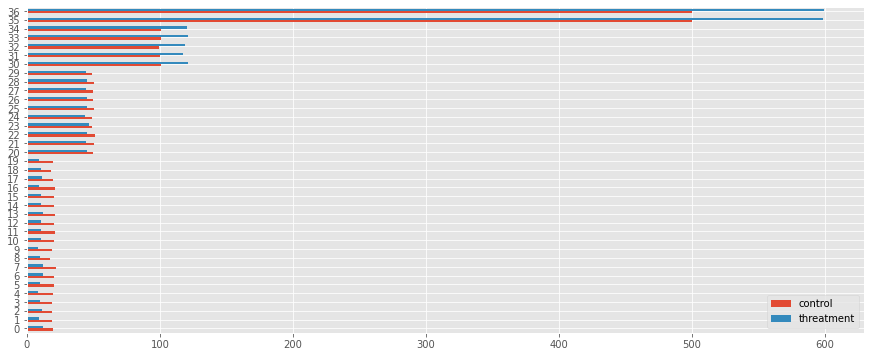

In [5]:
pd.DataFrame({'control':test_1,'threatment':test_2}).plot.barh()

In [6]:
pd.DataFrame({
    'Control':{'base':test_1.sum(),'log':np.log(test_1).sum()},
    'Threatment':{'base':test_2.sum(),'log':np.log(test_2).sum()}
})

,Control,Threatment
base,2396.503080,2451.628694
log,134.291472,121.225422


In [7]:
pd.DataFrame({
    'Control':{'base':test_1.mean(),'log':np.log(test_1).mean()},
    'Threatment':{'base':test_2.mean(),'log':np.log(test_2).mean()}
})

,Control,Threatment
base,64.770354,66.260235
log,3.629499,3.276363


In [8]:
# Упс, получается ровно противоположная картина.
# Т.е. суммарно заплатили денег больше, а в логарифме получилось меньше
# + Метрика логарифма трудно или вообще не интерпритируема для бизнеса
# В дальнейшем будет использоваться для референса

# База
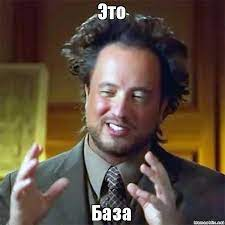

In [9]:
qq = sql_data.copy()

In [10]:
hahaha_ab_df = qq.pivot('user',['part','ab'],['view','click'])
hahaha_test = hahaha_ab_df['click'] / hahaha_ab_df['view']

In [11]:
test_of_tests['hahahah'] = {
                            'AA':sps.ttest_ind(hahaha_test['AA'][0].dropna(),hahaha_test['AA'][1].dropna()).pvalue,
                            'AB':sps.ttest_ind(hahaha_test['AB'][0].dropna(),hahaha_test['AB'][1].dropna()).pvalue,
                            }

In [12]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.64553,0.18029


In [13]:
effect_size['hahahah'] = hahaha_test.mean().unstack().apply(lambda x: x[1] - x[0],axis=1).to_dict()

In [14]:
test_of_tests['hahahah_log'] = {
                            'AA':sps.ttest_ind(hahaha_test['AA'][0].dropna().apply(np.log1p),hahaha_test['AA'][1].dropna().apply(np.log1p)).pvalue,
                            'AB':sps.ttest_ind(hahaha_test['AB'][0].dropna().apply(np.log1p),hahaha_test['AB'][1].dropna().apply(np.log1p)).pvalue,
                            }

In [15]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682


In [16]:
effect_size['hahahah_log'] = hahaha_test.apply(np.log1p).mean().unstack().apply(lambda x: x[1] - x[0],axis=1).to_dict()

# Настоящая база
<img src='https://www.meme-arsenal.com/memes/28beaa87227d46e0d91f2f3cb697f89c.jpg' width=400 height=400/>

In [17]:
# А настоящая база, когда мы проверили наш сет на предмет возможного пиздеца

In [18]:
# мммммммммммммммммммммммммммммммммммммммммммммм 1053 платежки за 2 недели ммммммммммммммммммммммммммммммм
sql_data[['view','click']].describe()

,view,click
count,181525.000000,181525.000000
mean,4.207757,0.323217
std,6.904729,1.041286
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,5.000000,0.000000
max,1055.000000,49.000000


In [19]:
# Убираем аккуратно, нужно брать бейзлайн именно с АА теста, чтобы в АБ у нас был унифицированная граница отрубания
views_aa_quantile = sql_data.query('part=="AA"')['view'].quantile(.99)
base = sql_data.copy().where(lambda x: x['view']<views_aa_quantile).dropna()

In [20]:
# Отдельно взятые средне не сместились, а вот разброс ушел - Мы молодцы!
base[['view','click']].describe()

,view,click
count,179537.000000,179537.000000
mean,3.734239,0.317834
std,3.873744,0.972961
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,5.000000,0.000000
max,29.000000,23.000000


In [21]:
base_test = base.groupby(['user','part','ab'])[['view','click']].sum().unstack([1,2])
base_test = base_test['click'] / base_test['view']

In [22]:
# CTR 200% mmmmmmmmmmmmmmm
base_test.describe()

part,AB,AA,AB,AA
ab,1.0,1.0,0.0,0.0
count,41079.000000,48537.000000,41229.000000,48692.000000
mean,0.081543,0.079013,0.079465,0.078322
std,0.217543,0.216069,0.216574,0.214190
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,2.000000,3.000000,2.000000,3.000000


In [23]:
base_test.where(lambda x: x<=1).dropna(thresh=1)

part,AB,AA,AB,AA
ab,1.0,1.0,0.0,0.0
user,,,,
1000001426235542855,0.0,NaN,NaN,NaN
10000041164695327753,0.0,NaN,NaN,NaN
10000437167754453419,0.2,0.0,NaN,NaN
100006266691692773,NaN,NaN,0.0,NaN
10000729822855793980,NaN,0.0,NaN,NaN
...,...,...,...,...
9999466463717575277,NaN,NaN,0.0,0.000000
9999470750505133276,NaN,NaN,0.0,0.142857


In [24]:
# Убираем наших уберкликеров
base_test = base_test.where(lambda x: x<=1).dropna(thresh=1)

In [25]:
base_test.describe()

part,AB,AA,AB,AA
ab,1.0,1.0,0.0,0.0
count,41060.000000,48479.000000,41211.000000,48634.000000
mean,0.080782,0.076894,0.078699,0.076247
std,0.214613,0.206963,0.213420,0.205294
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [26]:
test_of_tests['base'] = {
                            'AA':sps.ttest_ind(base_test['AA'][0].dropna(),base_test['AA'][1].dropna()).pvalue,
                            'AB':sps.ttest_ind(base_test['AB'][0].dropna(),base_test['AB'][1].dropna()).pvalue,
                            }

In [27]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682
base,0.624902,0.162786


In [28]:
effect_size['base'] = base_test.mean().unstack().apply(lambda x: x[1] - x[0],axis=1).to_dict()

In [29]:
test_of_tests['base_log'] = {
                            'AA':sps.ttest_ind(base_test['AA'][0].dropna().apply(np.log1p),base_test['AA'][1].dropna().apply(np.log1p)).pvalue,
                            'AB':sps.ttest_ind(base_test['AB'][0].dropna().apply(np.log1p),base_test['AB'][1].dropna().apply(np.log1p)).pvalue,
                            }
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682
base,0.624902,0.162786
base_log,0.679356,0.115914


In [30]:
effect_size['base_log'] = base_test.apply(np.log1p).mean().unstack().apply(lambda x: x[1] - x[0],axis=1).to_dict()

# Наш выбор если CTR (Linearization)
* Оч просто
* Но не понято

<img src='https://icdn.lenta.ru/images/2017/10/02/18/20171002185339048/original_d914c38487d8383acb871620d1d3eef3.jpg' width=400 height=400/>

In [31]:
# берем CTR контроля и считаем новую метрику, как разницу скликов и произведения просмотров на наш CTR контроля.
# По итогу получаем в обоих случаях среднее контрольной группы 0, а тритмента в размере нашего аплифта


In [32]:
linear_test = base.groupby(['user','part','ab'])[['view','click']].sum().unstack([1,2])

In [33]:
k = linear_test['click'].sum().div(linear_test['view'].sum()).unstack()[0].rename('k')

In [34]:
k

part
AA    0.087475
AB    0.079888
Name: k, dtype: float64

In [35]:
linear_test = linear_test['click'] - linear_test['view'].apply(lambda x: x * k[x.name[0]])

In [36]:
test_of_tests['linear'] = {
                            'AA':sps.ttest_ind(linear_test['AA'][0].dropna(),linear_test['AA'][1].dropna()).pvalue,
                            'AB':sps.ttest_ind(linear_test['AB'][0].dropna(),linear_test['AB'][1].dropna()).pvalue,
                            }

In [37]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682
base,0.624902,0.162786
base_log,0.679356,0.115914
linear,0.811256,0.012530


In [38]:
effect_size['linear'] = linear_test.mean().unstack().apply(lambda x: x[1] - x[0],axis=1).to_dict()

# Наш выбор если CTR Flex
* Оч просто
* Чуть понятнее

<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTpmP9dQlzF3siuqQNZhn042VnKknN10ZDa7Q&usqp=CAU' width=400 height=400/>

In [39]:
bayesian_test = base.groupby(['user','part','ab'])[['view','click']].sum().unstack([1,2]).sum()


In [40]:
AA_control = sps.beta(*bayesian_test.swaplevel(0,2)[0]['AA'][['click','view']].values).rvs(10000)
AA_threatment = sps.beta(*bayesian_test.swaplevel(0,2)[1]['AA'][['click','view']].values).rvs(10000)
AB_control = sps.beta(*bayesian_test.swaplevel(0,2)[0]['AB'][['click','view']].values).rvs(10000)
AB_threatment = sps.beta(*bayesian_test.swaplevel(0,2)[1]['AB'][['click','view']].values).rvs(10000)

Text(0.5, 1.0, 'AA test')

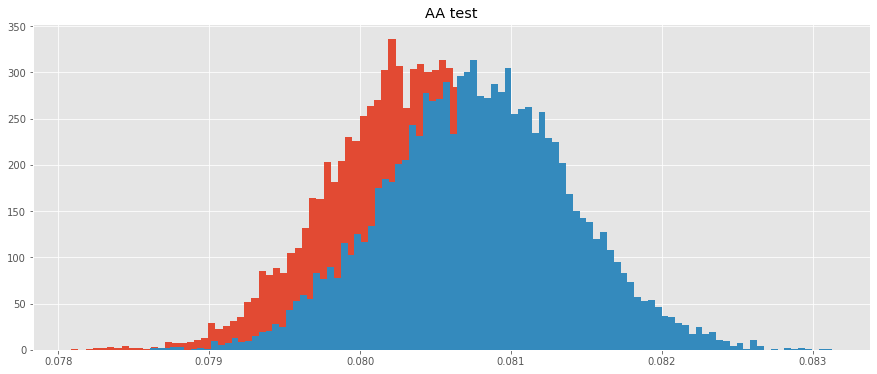

In [41]:
plt.hist(AA_control,bins=100);
plt.hist(AA_threatment,bins=100);
plt.title('AA test')

Text(0.5, 1.0, 'AB test')

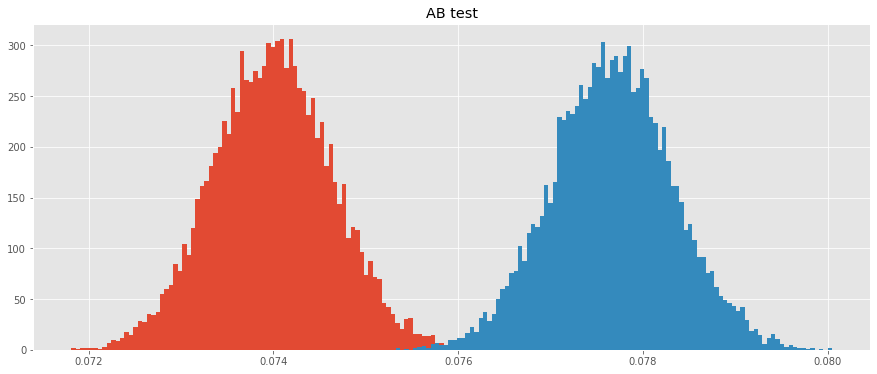

In [42]:
plt.hist(AB_control,bins=100);
plt.hist(AB_threatment,bins=100);
plt.title('AB test')

In [43]:
# А как формализовать? 

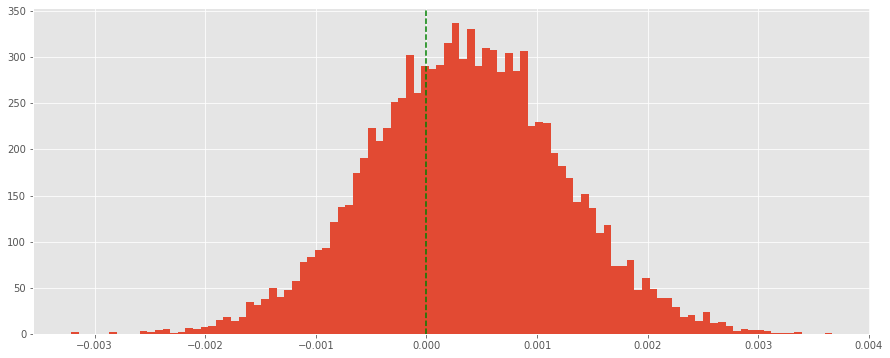

In [44]:
# Посмотрим разницу
plt.hist(AA_threatment - AA_control,bins=100);
plt.axvline(0,linestyle='--',color='g')

Text(0.5, 1.0, 'Вероятность того, что вариант Б лучше 65.50%')

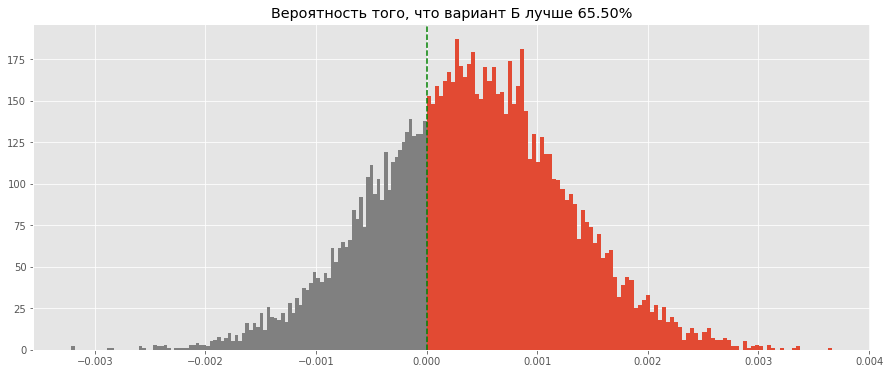

In [45]:
# А теперь посчитаем сколько в скольких случаев тритмент лучше нашего контроля
# Серая область это когда лучше контроль, красная, когда лучше тритмент
# И теперь оцениваем объем и сравниваем
plt.hist((AA_threatment - AA_control)[(AA_threatment - AA_control)<0],bins=100,color='grey');
plt.hist((AA_threatment - AA_control)[(AA_threatment - AA_control)>0],bins=100);
plt.axvline(0,linestyle='--',color='g')
plt.title(f'Вероятность того, что вариант Б лучше {(AA_threatment > AA_control).mean():.2%}')

Text(0.5, 1.0, 'Вероятность того, что вариант Б лучше 100.00%')

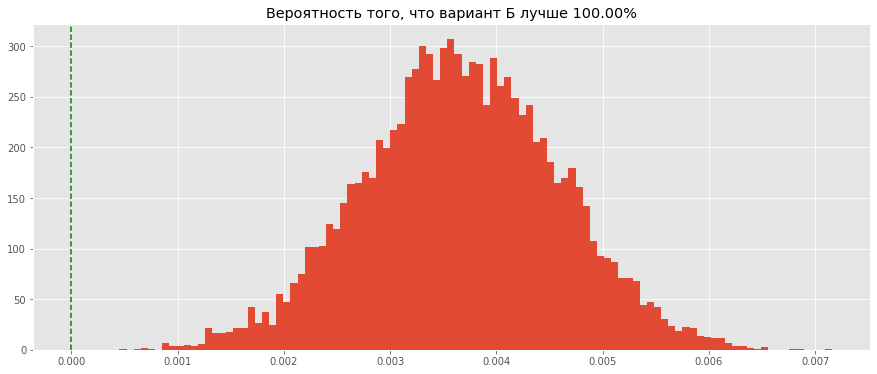

In [46]:
# Посмотрим разницу
plt.hist(AB_threatment - AB_control,bins=100);
plt.axvline(0,linestyle='--',color='g')
plt.title(f'Вероятность того, что вариант Б лучше {(AB_threatment > AB_control).mean():.2%}')

Text(0.5, 1.0, 'Uplift от наших улучшений 4.72%')

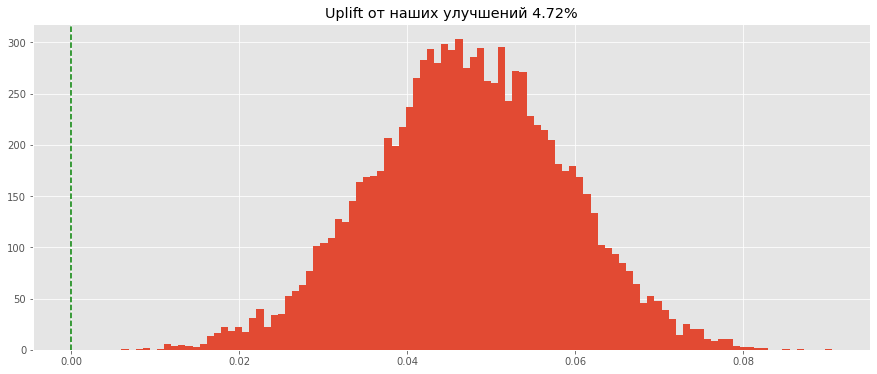

In [47]:
# Посмотрим разницу
plt.hist((AB_threatment - AB_control) / AB_threatment,bins=100);
plt.axvline(0,linestyle='--',color='g')
plt.title(f'Uplift от наших улучшений {((AB_threatment - AB_control) / AB_threatment).mean():.2%}')

In [48]:
test_of_tests['bayesian'] = {
                            'AA':min((AA_threatment > AA_control).mean(),1 - (AA_threatment > AA_control).mean()) * 2,
                            'AB':min((AB_threatment > AB_control).mean(),1 - (AB_threatment > AB_control).mean()) * 2,
                            }

In [49]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682
base,0.624902,0.162786
base_log,0.679356,0.115914
linear,0.811256,0.012530
bayesian,0.690000,0.000000


In [50]:
effect_size ['bayesian'] = {'AA':AA_threatment.mean() - AA_control.mean(),
                            'AB':AB_threatment.mean() - AB_control.mean()}

# Наш выбор если CTR + важна активность (Перевзвешивание)
* Сложновато
* Зато понятно почему

<img src='http://images2.memedroid.com/images/UPLOADED37/5160beb129d16.jpeg' width=400 height=400/>

In [51]:
reweight_test = base.groupby(['user','part','ab'])[['view','click']].sum().unstack([1,2])

In [52]:
weight_coef = np.sqrt(reweight_test['view'])

In [53]:
# average CTR
avg_ctr = (reweight_test['click'] / reweight_test['view']).mean().unstack()
avg_ctr

ab,0.0,1.0
part,,
AA,0.078322,0.079013
AB,0.079465,0.081543


In [54]:
# Global CTR
global_ctr = (reweight_test['click'].sum() / reweight_test['view'].sum()).unstack()
global_ctr

ab,0.0,1.0
part,,
AA,0.087475,0.087872
AB,0.079888,0.084196


In [55]:
# С нелинейным учетом веса
reweight_ctr = reweight_test['click'].div(reweight_test['view']).mul(weight_coef).div(weight_coef.mean()).mean().unstack()
reweight_ctr

ab,0.0,1.0
part,,
AA,0.085383,0.085793
AB,0.082261,0.085341


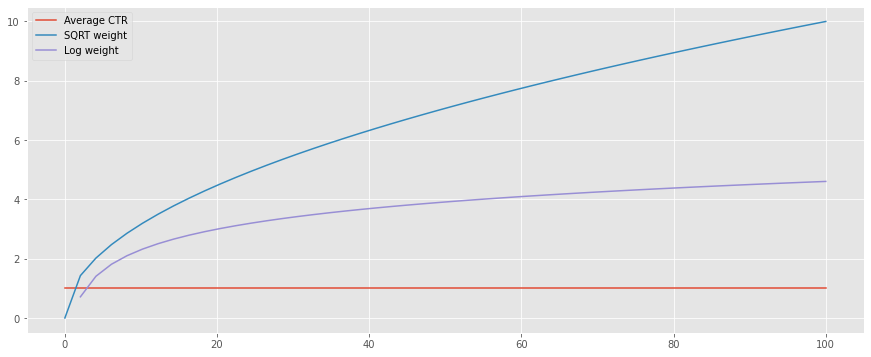

In [56]:
# Различные веса
# plt.plot(np.linspace(0,100),np.linspace(0,100))
plt.plot(np.linspace(0,100),np.ones(50))
plt.plot(np.linspace(0,100),np.linspace(0,100)**.5)
plt.plot(np.linspace(0,100),np.log(np.linspace(0,100)))
plt.legend(['Average CTR','SQRT weight','Log weight'])

In [57]:
alpha = 1
kw = reweight_test['click'].sum().div(reweight_test['view'].sum()) * alpha
reweight_test['click'].add( kw).div(reweight_test['view'].add( alpha)).mean().unstack()

ab,0.0,1.0
part,,
AA,0.084824,0.085256
AB,0.081980,0.085075


In [58]:
alpha_df = []
for alpha in np.linspace(0,1):
    kw = reweight_test['click'].sum().div(reweight_test['view'].sum()) * alpha
    alpha_df.append(reweight_test['click'].add( kw).div(reweight_test['view'].add( alpha)).mean().rename(alpha))
alpha_df = pd.concat(alpha_df,axis=1)

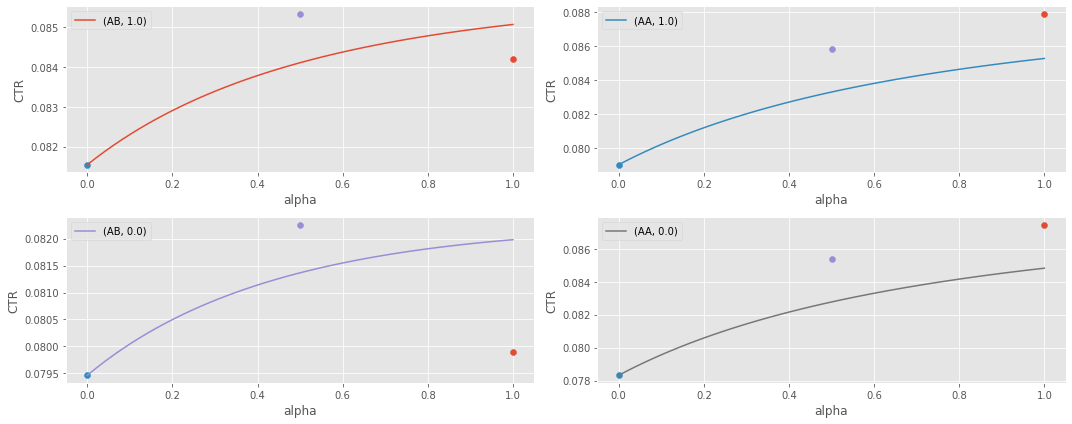

In [59]:
fig,ax = plt.subplots(2,2)
alpha_df.T.plot(subplots=True,ax=ax,xlabel='alpha',ylabel='CTR')
ax[0,0].scatter(x=1,y=global_ctr.loc['AB',1])
ax[0,0].scatter(x=0,y=avg_ctr.loc['AB',1])
ax[0,0].scatter(x=.5,y=reweight_ctr.loc['AB',1])


ax[0,1].scatter(x=1,y=global_ctr.loc['AA',1])
ax[0,1].scatter(x=0,y=avg_ctr.loc['AA',1])
ax[0,1].scatter(x=.5,y=reweight_ctr.loc['AA',1])

ax[1,0].scatter(x=1,y=global_ctr.loc['AB',0])
ax[1,0].scatter(x=0,y=avg_ctr.loc['AB',0])
ax[1,0].scatter(x=.5,y=reweight_ctr.loc['AB',0])

ax[1,1].scatter(x=1,y=global_ctr.loc['AA',0])
ax[1,1].scatter(x=0,y=avg_ctr.loc['AA',0])
ax[1,1].scatter(x=.5,y=reweight_ctr.loc['AA',0])
plt.tight_layout()

In [60]:
reweight_test_df = reweight_test['click'].add( kw).div(reweight_test['view'].add( alpha))

In [61]:
test_of_tests['reweight_ctr_coef'] = {
                            'AA':sps.ttest_ind(reweight_test_df['AA'][0].dropna(),reweight_test_df['AA'][1].dropna()).pvalue,
                            'AB':sps.ttest_ind(reweight_test_df['AB'][0].dropna(),reweight_test_df['AB'][1].dropna()).pvalue,
                            }

In [62]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682
base,0.624902,0.162786
base_log,0.679356,0.115914
linear,0.811256,0.012530
bayesian,0.690000,0.000000
reweight_ctr_coef,0.656736,0.003065


In [63]:
effect_size['reweight_ctr_coef'] = reweight_test_df.mean().unstack().apply(lambda x: x[1] - x[0],axis=1).to_dict()

In [64]:
reweight_test_df = reweight_test['click'].div(reweight_test['view']).mul(weight_coef).div(weight_coef.mean())

In [65]:
test_of_tests['reweight_ctr'] = {
                            'AA':sps.ttest_ind(reweight_test_df['AA'][0].dropna(),reweight_test_df['AA'][1].dropna()).pvalue,
                            'AB':sps.ttest_ind(reweight_test_df['AB'][0].dropna(),reweight_test_df['AB'][1].dropna()).pvalue,
                            }

In [66]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682
base,0.624902,0.162786
base_log,0.679356,0.115914
linear,0.811256,0.012530
bayesian,0.690000,0.000000
reweight_ctr_coef,0.656736,0.003065
reweight_ctr,0.779160,0.045775


In [67]:
effect_size['reweight_ctr_log'] = reweight_test_df.mean().unstack().apply(lambda x: x[1] - x[0],axis=1).to_dict()

# В любой непонятной ситуации (Bucketing)
<img src='https://i.pinimg.com/736x/7a/97/bd/7a97bd9304643c2d27fb6ef2dbb0cf07.jpg'>

In [68]:
bucket_test = base.groupby(['user','part','ab'])[['view','click']].sum().unstack([1,2])

In [69]:
bucket_size = 100
n_buckets = bucket_test['view'].count().min() // bucket_size

In [70]:
bucket_df = {}
part_ab = bucket_test.swaplevel(0,2,axis=1).droplevel(2,axis=1).columns.unique()
for exp in part_ab:

    tmp = []

    for bucket in tqdm(range(n_buckets)):

        meta_user = bucket_test.swaplevel(0,2,axis=1).loc[:,exp].iloc[bucket * bucket_size: (bucket+1) * bucket_size].sum()
        
        ctr_meta_user = meta_user['click'] / meta_user['view']
        tmp.append(ctr_meta_user)

    bucket_df.update({exp:tmp})
bucket_df = pd.DataFrame(bucket_df)

100%|██████████| 410/410 [00:01<00:00, 267.29it/s]


array([[<AxesSubplot:title={'center':"(1.0, 'AB')"}>,
        <AxesSubplot:title={'center':"(1.0, 'AA')"}>],
       [<AxesSubplot:title={'center':"(0.0, 'AB')"}>,
        <AxesSubplot:title={'center':"(0.0, 'AA')"}>]], dtype=object)

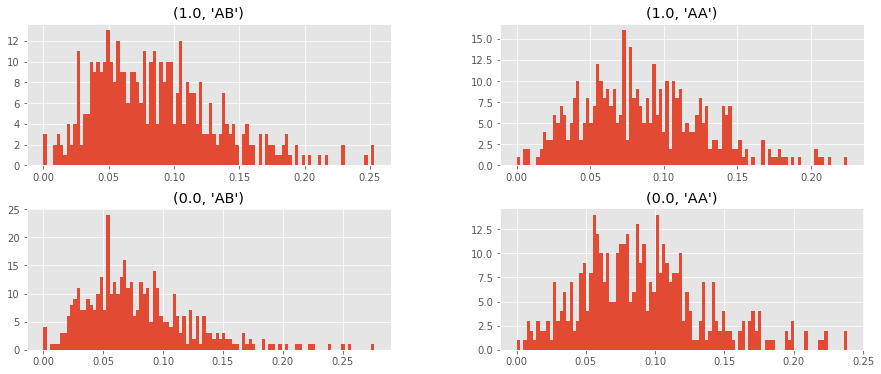

In [71]:
bucket_df.hist(bins=100)

In [72]:
test_of_tests['bucketing'] = {
                                'AA':sps.ttest_ind(pd.DataFrame(bucket_df).loc[:,(1,'AA')].dropna(),pd.DataFrame(bucket_df).loc[:,(0,'AA')].dropna()).pvalue,
                                'AB':sps.ttest_ind(pd.DataFrame(bucket_df).loc[:,(1,'AB')].dropna(),pd.DataFrame(bucket_df).loc[:,(0,'AB')].dropna()).pvalue,
                                }

In [73]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682
base,0.624902,0.162786
base_log,0.679356,0.115914
linear,0.811256,0.012530
bayesian,0.690000,0.000000
reweight_ctr_coef,0.656736,0.003065
reweight_ctr,0.779160,0.045775
bucketing,0.140327,0.032743


In [74]:
effect_size['bucketing'] = bucket_df.mean().unstack().apply(lambda x: x[1] - x[0]).to_dict()

# В любой непонятной ситуации v2 ~~может не влезть по памяти~~ (Bootstrap)
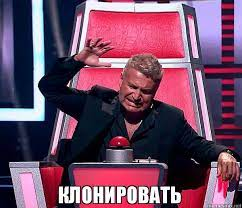

In [75]:
bootstrap_test = base.groupby(['user','part','ab'])[['view','click']].sum().unstack([1,2])

In [76]:
bootstrap_test_ctr = bootstrap_test['click'] / bootstrap_test['view']

In [77]:

min_size = bootstrap_test_ctr.count().min()
rr = np.random.default_rng(11)
bts_aa = []
bts_ab = []
for _ in tqdm(range(1000)):

    aa_c = rr.choice(bootstrap_test['click']['AA'][0].dropna().values,size=min_size,replace=True).sum() / rr.choice(bootstrap_test['view']['AA'][0].dropna().values,size=min_size,replace=True).sum()
    aa_t = rr.choice(bootstrap_test['click']['AA'][1].dropna().values,size=min_size,replace=True).sum() / rr.choice(bootstrap_test['view']['AA'][1].dropna().values,size=min_size,replace=True).sum()
    bts_aa.append(aa_t - aa_c)

    ab_c = rr.choice(bootstrap_test['click']['AB'][0].dropna().values,size=min_size,replace=True).sum() / rr.choice(bootstrap_test['view']['AB'][0].dropna().values,size=min_size,replace=True).sum()
    ab_t = rr.choice(bootstrap_test['click']['AB'][1].dropna().values,size=min_size,replace=True).sum() / rr.choice(bootstrap_test['view']['AB'][1].dropna().values,size=min_size,replace=True).sum()
    bts_ab.append(ab_t - ab_c)
bts_aa = np.array(bts_aa)
bts_ab = np.array(bts_ab)

100%|██████████| 1000/1000 [00:37<00:00, 26.42it/s]


In [78]:
test_of_tests['bootstrap'] = {
                                'AA':min((bts_aa <0).sum(),len(bts_aa) - (bts_aa <0).sum()) / len(bts_aa),
                                'AB':min((bts_ab <0).sum(),len(bts_ab) - (bts_ab <0).sum()) / len(bts_ab),
                                }

In [79]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682
base,0.624902,0.162786
base_log,0.679356,0.115914
linear,0.811256,0.012530
bayesian,0.690000,0.000000
reweight_ctr_coef,0.656736,0.003065
reweight_ctr,0.779160,0.045775
bucketing,0.140327,0.032743
bootstrap,0.409000,0.010000


In [80]:
effect_size['bootstrap'] = {'AA':bts_aa.mean(),
                            'AB':bts_ab.mean()}

# Combo Breaker
<img src = 'https://y.yarn.co/2c879f9a-f5b7-4eb8-8791-6328d8a2c877_screenshot.jpg'>

In [81]:
combo_test = base.groupby(['user','part','ab'])[['view','click']].sum().unstack([1,2])

In [82]:
AA_combo_df = generate_tests(*combo_test.swaplevel(0,2,axis=1)[0]['AA'].dropna().T.values,
                            *combo_test.swaplevel(0,2,axis=1)[1]['AA'].dropna().T.values)

In [83]:
AB_combo_df = generate_tests(*combo_test.swaplevel(0,2,axis=1)[0]['AB'].dropna().T.values,
                            *combo_test.swaplevel(0,2,axis=1)[1]['AB'].dropna().T.values)

In [84]:
AB_combo_df.T.sort_values(by='ci_lenght')

,ttest,mwtest,uplift,relative_uplift,ci_left,ci_right,ci_lenght,ci_left_lenght
Combo,0.000074,NaN,0.003679,0.049733,0.001857,0.005492,0.003635,0.000222
bayesian,0.000076,NaN,0.003679,0.049733,0.001854,0.005493,0.003639,0.000224
base,0.169505,0.052352,0.002079,0.026160,-0.000887,0.005044,0.005931,0.002966
ML,0.169510,NaN,0.002079,0.026160,-0.000887,0.005045,0.005932,0.002966
reweight,0.044465,0.048607,0.003098,0.037673,0.000077,0.006120,0.006043,0.003022
bootstrap,0.016000,NaN,0.004143,0.051795,0.001060,0.007265,0.006205,0.001019
bucketing,0.014046,0.010675,0.004261,0.053132,0.000861,0.007661,0.006801,0.003400
linearization,0.012534,0.150574,0.015909,NaN,0.003420,0.028398,0.024978,0.012489


In [85]:
AB_combo_df.T.sort_values(by='ci_left_lenght')

,ttest,mwtest,uplift,relative_uplift,ci_left,ci_right,ci_lenght,ci_left_lenght
Combo,0.000074,NaN,0.003679,0.049733,0.001857,0.005492,0.003635,0.000222
bayesian,0.000076,NaN,0.003679,0.049733,0.001854,0.005493,0.003639,0.000224
bootstrap,0.016000,NaN,0.004143,0.051795,0.001060,0.007265,0.006205,0.001019
base,0.169505,0.052352,0.002079,0.026160,-0.000887,0.005044,0.005931,0.002966
ML,0.169510,NaN,0.002079,0.026160,-0.000887,0.005045,0.005932,0.002966
reweight,0.044465,0.048607,0.003098,0.037673,0.000077,0.006120,0.006043,0.003022
bucketing,0.014046,0.010675,0.004261,0.053132,0.000861,0.007661,0.006801,0.003400
linearization,0.012534,0.150574,0.015909,NaN,0.003420,0.028398,0.024978,0.012489
